<a href="https://colab.research.google.com/github/tekassh1/CPUModel/blob/main/Statistic_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.linear_model import LinearRegression

data = pd.read_csv('/content/drive/My Drive/DataForColab/fifa_players_stats.csv');

# Y = Dependent Variable (Value of player)
# X1, X2, X3 = Independent variables (rating, potential rating, age)

Y = data['Value(in Euro)']
X1 = data['Overall']
X2 = data['Potential']
X3 = data['Age']

X = np.column_stack([X1, X2, X3, np.ones(len(X1))])
coefs = np.linalg.inv(X.T @ X) @ X.T @ Y
print("Коэфициенты полученные вручную: ", *coefs)

# Get coefs with sklearn
X_clear = np.column_stack([X1, X2, X3])
model = LinearRegression().fit(X_clear, Y)
print("Коэфициенты полученные sklearn: ",*model.coef_, model.intercept_)

Коэфициенты полученные вручную:  698157.3636899727 77438.21069601385 -367934.69773160975 -39312206.65067077
Коэфициенты полученные sklearn:  698157.3636899878 77438.21069598569 -367934.6977316366 -39312206.650668904


Построим графики зависимостей

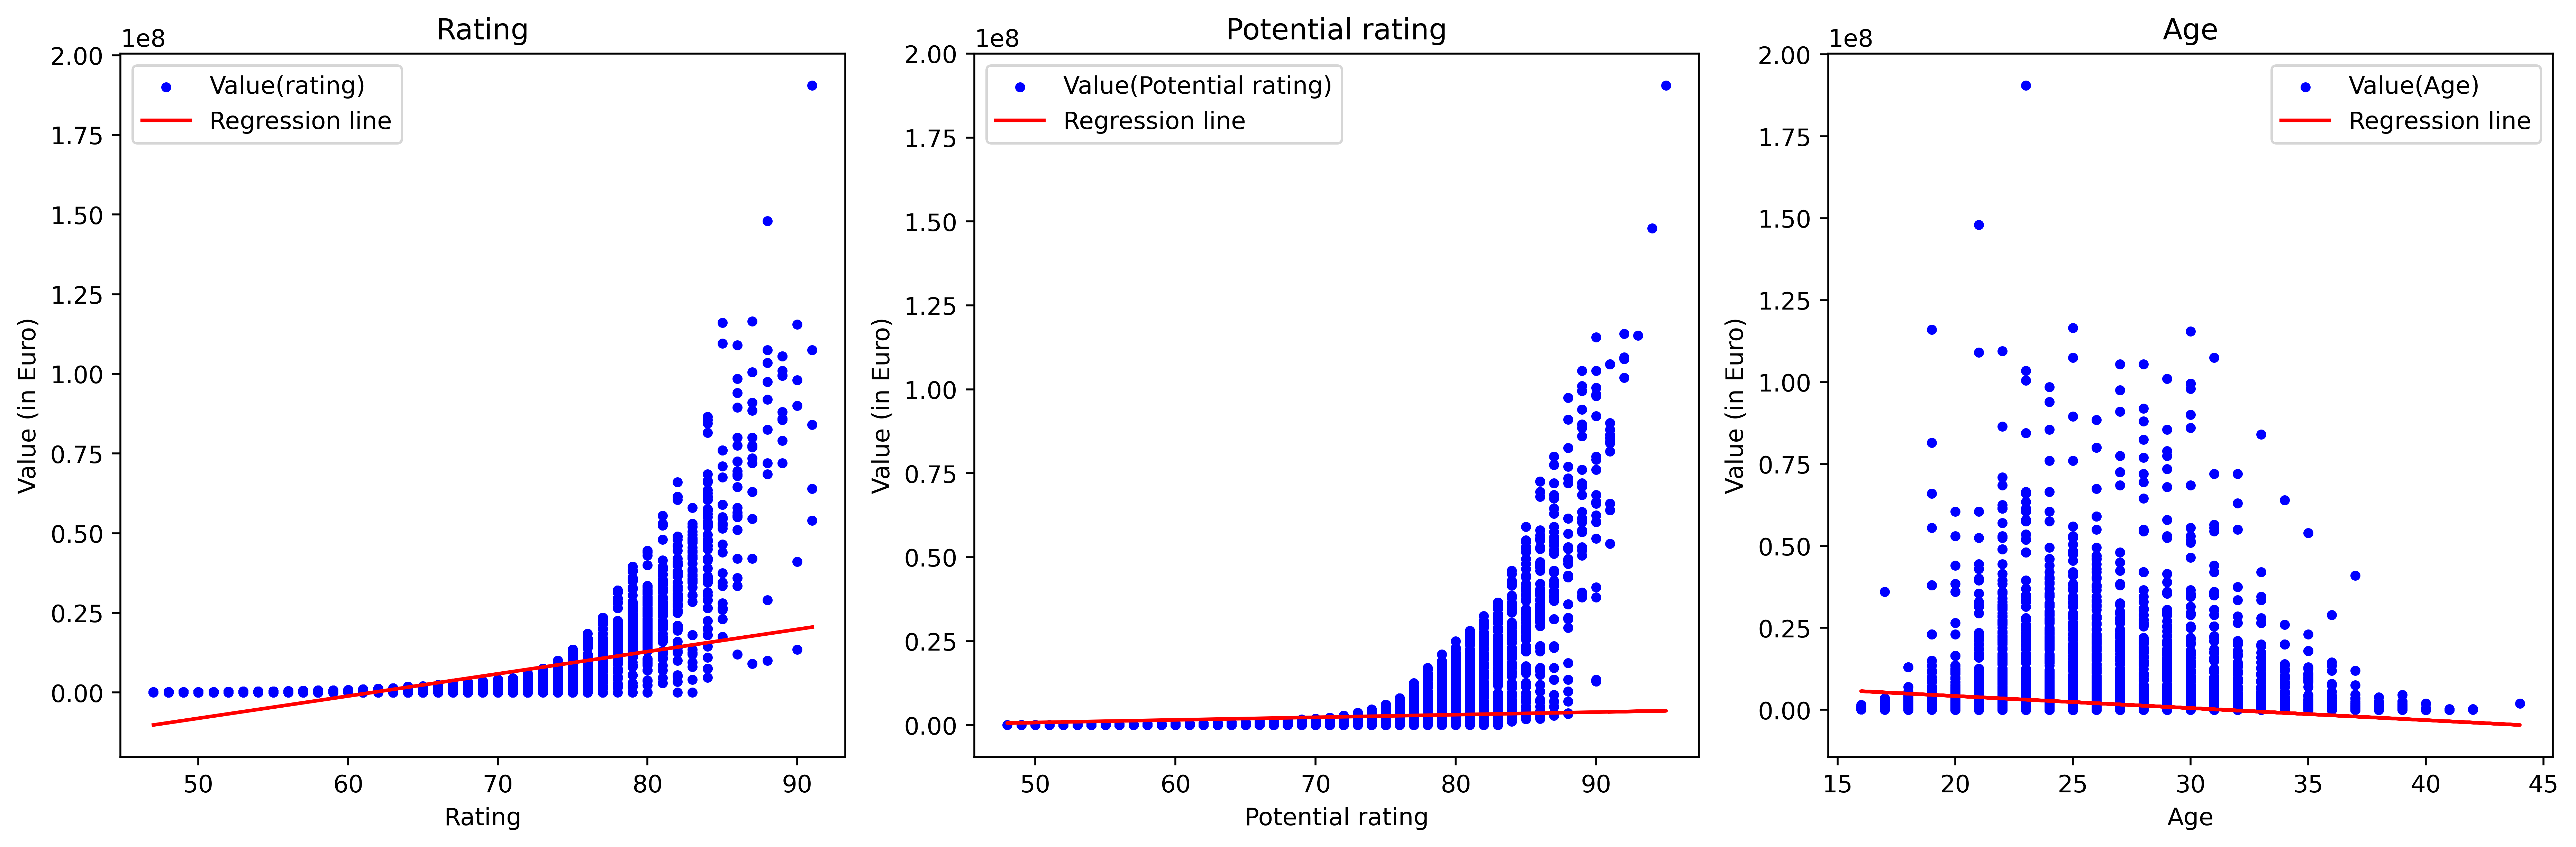

In [31]:
# Предсказание значений Y на основе модели
predicted_Y = model.predict(X_clear)

# График для X1 (Rating)
plt.figure(figsize=(15, 5), dpi=500)

plt.subplot(1, 3, 1)
plt.scatter(X1, Y, color='blue', label='Value(rating)', s=10)
plt.plot(X1, model.predict(np.column_stack([X1, np.full_like(X1, X2.mean()), np.full_like(X1, X3.mean())])), color='red', label='Regression line')
plt.title('Rating')
plt.xlabel('Rating')
plt.ylabel('Value (in Euro)')
plt.legend()

# График для X2 (Potential rating)
plt.subplot(1, 3, 2)
plt.scatter(X2, Y, color='blue', label='Value(Potential rating)', s=10)
plt.plot(X2, model.predict(np.column_stack([np.full_like(X2, X1.mean()), X2, np.full_like(X2, X3.mean())])), color='red', label='Regression line')
plt.title('Potential rating')
plt.xlabel('Potential rating')
plt.ylabel('Value (in Euro)')
plt.legend()

# График для X3 (Age)
plt.subplot(1, 3, 3)
plt.scatter(X3, Y, color='blue', label='Value(Age)', s=10)
plt.plot(X3, model.predict(np.column_stack([np.full_like(X3, X1.mean()), np.full_like(X3, X2.mean()), X3])), color='red', label='Regression line')
plt.title('Age')
plt.xlabel('Age')
plt.ylabel('Value (in Euro)')
plt.legend()

plt.tight_layout()
plt.show()

Рассчитаем оценку остаточной дисперсии:

$\frac{RSS}{n - k}$, где $n$ - число наблюдений, $k$ - число параметров регрессии (включая свободный член)

$RSS = \sum_{i=1}^{n}(Y_i - X_ic) = (Y-Xс)^T(Y-Xс)$

In [32]:
n = len(X1)
k = 4
rss = (Y - X @ coefs).T @ (Y - X @ coefs)
S = rss/(n-k)
print("Оценка остаточной дисперсии: ", S)

Оценка остаточной дисперсии:  36433212420081.29


Рассчитаем коэфициент детерминации:

$R^2 = 1 - \frac{SSE}{SST}$, где

$SSE = \sum_{i=1}^{n}(Y - \hat{Y})$ - сумма квадратов остатков регрессии (sum square of errors)

$SST = \sum_{i=1}^{n}(Y - \bar{Y})$ - полная сумма квадратов (sum square total)

In [33]:
Yhat = X @ coefs
sse = np.sum((Y - Yhat) ** 2)
sst = np.sum((Y - np.mean(Y)) ** 2)

r2 = 1 - sse/sst
print("Коэфициент детерминации: ", r2)

Коэфициент детерминации:  0.3751231636281871


Рассчитаем доверительный интервал для параметров модели:

$[\hat{\beta}_i - t_{\frac{\alpha}{2}, n-p-1} \times SE(\hat{\beta}_i), \hat{\beta}_i + t_{\frac{\alpha}{2}, n-p-1} \times SE(\hat{\beta}_i)]$

In [37]:
p = X.shape[1]
df = n - p - 1
alpha = 0.05

mse = np.sum((Y - Yhat)**2) / (len(Y) - p)
se = np.sqrt(np.diagonal(mse * np.linalg.inv(X.T @ X)))
tStat = coefs/se
t_critical = sc.stats.t.ppf(1 - alpha/2, df)

CI = []
for i in range(len(coefs)):
  CI.append((coefs[i] - t_critical * se[i], coefs[i] + t_critical * se[i]))
print("Доверительные интервалы для параметров модели: ", CI)

Доверительные интервалы для параметров модели:  [(665644.434241476, 730670.2931384693), (44303.032083769875, 110573.38930825781), (-404340.4290338175, -331528.966429402), (-40775229.835299276, -37849183.46604226)]


Рассчитаем доверительный интервал для остаточной дисперсии

$(n-m)\frac{S^2(\widehat{c})}{σ^2} \sim χ^2(n-m)$

Выразим остаточную дисперсию

$\frac{S^2(\widehat{c})(n-m)}{χ^2_{1-α/2,(n-m)}} < σ^2 < \frac{S^2(\widehat{c})(n-m)}{χ^2_{α/2,(n-m)}}$

In [39]:
print("Доверительный интервалы остаточной дисперсии:")
print(S * (n - p) / sc.stats.chi2.ppf(1 - alpha / 2, n - p))
print(S * (n - p) / sc.stats.chi2.ppf(alpha / 2, n - p))

Доверительный интервалы остаточной дисперсии:
35702682227620.766
37186502819522.484
